In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import talib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks.callbacks import ReduceLROnPlateau, EarlyStopping

import shap


%matplotlib inline

Using TensorFlow backend.
/home/stephen/Projects/stock_price/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/Projects/stock_price/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/Projects/stock_price/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/st

# Get the data

In [2]:
df = pd.read_csv('ohlc_data.csv', index_col='Date')
df.head()

,Open,Close,High,Low,Trades,Volume,Y
Date,,,,,,,
2018-01-01T00:00:00.000Z,13838.5,13873.0,13961.0,13838.0,958,2041363,0
2018-01-01T00:05:00.000Z,13873.0,13800.0,13920.0,13800.0,1151,2595550,0
2018-01-01T00:10:00.000Z,13800.0,13771.5,13800.5,13675.0,1859,5809735,0
2018-01-01T00:15:00.000Z,13771.5,13769.0,13795.0,13711.0,861,1816360,0
2018-01-01T00:20:00.000Z,13769.0,13702.0,13775.5,13596.0,1235,4967912,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192212 entries, 2018-01-01T00:00:00.000Z to 2019-10-30T09:35:00.000Z
Data columns (total 7 columns):
Open      192212 non-null float64
Close     192212 non-null float64
High      192212 non-null float64
Low       192212 non-null float64
Trades    192212 non-null int64
Volume    192212 non-null int64
Y         192212 non-null int64
dtypes: float64(4), int64(3)
memory usage: 11.7+ MB


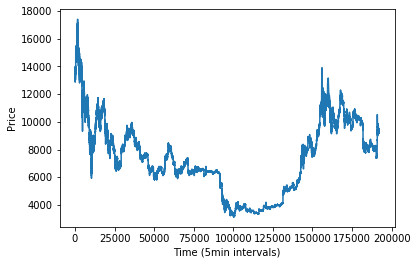

In [5]:
# Plot data
plt.plot(df['Close'].values)
plt.ylabel('Price')
plt.xlabel('Time (5min intervals)')
plt.show()

In [6]:
# convert 'Volume' from integer to float
df['Volume'] = df['Volume'].astype('float')

In [7]:
print('Total instances:', df.shape[0])
print('Features:', *df.columns)

Total instances: 192212
Features: Open Close High Low Trades Volume Y


In [8]:
df.isnull().values.any()

False

## Create Features

In [9]:
# Get Moving Average Convergance/Divergance
df['macd'], macdsignal, machist = talib.MACD(df['Close'].values, fastperiod=26, slowperiod=12,
                                       signalperiod=9)
# Get Willams'%R
df['williamsR'] = talib.WILLR(df['High'].values, df['Low'].values,
                              df['Close'].values, timeperiod=15)
# Get Average Directional Movement Index
df['ADX'] = talib.ADX(df['High'].values, df['Low'].values,
                      df['Close'].values, timeperiod=15)
# Get Relative Strength Index
df['RSI'] = talib.RSI(df['Close'].values, timeperiod=15)

# Get Log Momentum, different timeframes
df['log_mom20'] = talib.MOM(df['Close'].values, 20)
df['log_mom5'] = talib.MOM(df['Close'].values, 5)
df['log_mom1'] = talib.MOM(df['Close'].values, 1)

In [10]:
# Create target variable, 3 rows (15 minutes) ahead
df['shifted_close'] = df['Close'].shift(-3)
df['Target'] = (df['shifted_close'] - df['Close'] > 0).astype(int)

In [11]:
# Drop unnecessary columns and na's
target_values = df['Target'].values

df.drop(['shifted_close', 'Target', 'Trades', 'Y'], 1, inplace=True)
df.dropna(inplace=True)

## Split and scale the data

In [13]:
# Split the data into training and testing
train_df = df.loc[:'2019-09-01']
test_df = df.loc['2019-09-01':]

split_idx = train_df.shape[0]
training_labels = target_values[:split_idx]
test_labels = target_values[split_idx:]

In [14]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(train_df)
test_data = scaler.transform(test_df)

In [23]:
# Split data into train/validation 80/20
validation_len = math.ceil(len(training_data) * 0.2)

timestep = 100

train_data = training_data[validation_len:, :]
train_labels = training_labels[validation_len:]

validation_data = training_data[0:validation_len - timestep, :]
validation_labels = training_labels[0:validation_len - timestep:]

# Create batches for training
X_train = []
y_train = []
X_val = []
y_val = []
for i in range(timestep, len(train_data)):
    X_train.append(train_data[i-timestep:i])
    y_train.append(train_labels[i])
    
for i in range(timestep, len(validation_data)):
    X_val.append(validation_data[i-timestep:i])
    y_val.append(validation_labels[i])

In [24]:
# Convert data from lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

## Create the model

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=False,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(50))
model.add(Dense(1, activation='sigmoid'))

In [26]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           12600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 35,401
Trainable params: 35,401
Non-trainable params: 0
_________________________________________________________________


In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                      patience=1, verbose=1, mode='auto',
                      min_delta=0.0001, cooldown=0, min_lr=0),
    EarlyStopping(monitor='val_loss', patience=2)
]

In [30]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    validation_split=0.2,
                    epochs=15,
                    callbacks=callbacks
                    )


Train on 111964 samples, validate on 27992 samples
Epoch 1/15
111964/111964 [==============================] - 270s 2ms/step - loss: 0.5763 - accuracy: 0.6955 - val_loss: 0.5119 - val_accuracy: 0.7445
Epoch 2/15
111964/111964 [==============================] - 270s 2ms/step - loss: 0.4746 - accuracy: 0.7683 - val_loss: 0.4403 - val_accuracy: 0.7913
Epoch 3/15
111964/111964 [==============================] - 269s 2ms/step - loss: 0.4267 - accuracy: 0.7985 - val_loss: 0.4037 - val_accuracy: 0.8116
Epoch 4/15
111964/111964 [==============================] - 268s 2ms/step - loss: 0.3945 - accuracy: 0.8153 - val_loss: 0.3724 - val_accuracy: 0.8299
Epoch 5/15
111964/111964 [==============================] - 268s 2ms/step - loss: 0.3719 - accuracy: 0.8284 - val_loss: 0.3880 - val_accuracy: 0.8208

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/15
111964/111964 [==============================] - 268s 2ms/step - loss: 0.3339 - accuracy: 0.8487 - val_lo

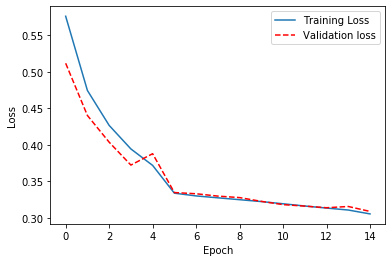

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'r--')
plt.legend(['Training Loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

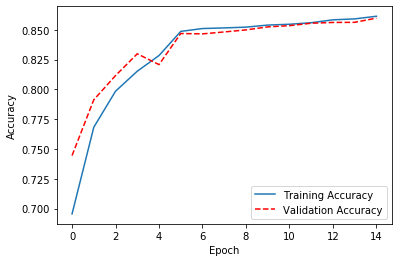

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], 'r--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('lstm_accuracy.png')
plt.show()

In [31]:
# Check validation accuracy
val_preds = model.predict(X_val)
binary_val_preds = [1 if i > 0.5 else 0 for i in val_preds]
accuracy_score(y_val, binary_val_preds)

0.8497486715496194

## Use SHAP to examine feature importance

In [32]:
explainer = shap.DeepExplainer(model, X_train[:50])
shap_values = explainer.shap_values(X_val[:50])

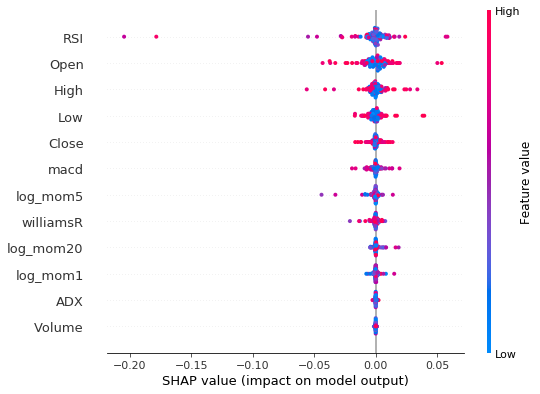

In [33]:
features = train_df.columns
shap.summary_plot(shap_values[0][0], X_train[0],
                  feature_names=features)

## Get test accuracy

In [34]:
X_test = []
y_test = []

for i in range(timestep, len(test_data)):
    X_test.append(test_data[i-timestep:i])
    y_test.append(test_labels[i])

In [35]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [36]:
test_preds = model.predict(X_test)
binary_test_preds = [1 if i > 0.5 else 0 for i in test_preds]
accuracy_score(y_test, binary_test_preds)

0.8661218250235183